In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths

from openpathsampling.storage import Storage

storage = Storage("_toy_retis.nc", "r")

In [3]:
len(storage.steps)

201

In [4]:
retis = storage.transitions.load(0)

In [5]:
%%time
storage.samples.cache_all()

CPU times: user 128 ms, sys: 23.3 ms, total: 151 ms
Wall time: 151 ms


### Defining labels

Everything is actually done in terms of ensembles. We can map the ensembles to any labels. In our case, we use the initial replica ID associated with the ensemble. We use this as both the numeric and string label.

In [6]:
sset0 = storage.samplesets[0]
numeric_labels = { s.ensemble : s.replica for s in sset0}
string_labels = { s.ensemble : str(s.replica) for s in sset0 }
numeric_to_string = { numeric_labels[e] : string_labels[e] for e in numeric_labels.keys()}

## Trace of ensemble visited by a replica

In the plot below, you'll see we set the labels on the axis as sset0[e].replica, so we use the replica ID associated with the ensemble in the first timestep.

In [7]:
%%time
trace_1 = paths.trace_ensembles_for_replica(0, storage)

CPU times: user 2.86 s, sys: 484 ms, total: 3.34 s
Wall time: 3.34 s


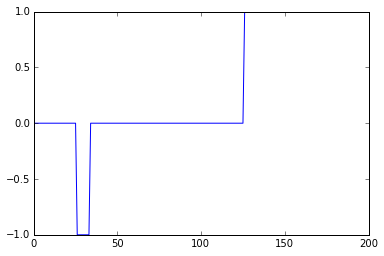

In [8]:
plt.plot([numeric_labels[e] for e in trace_1])

### Replica flow

In [9]:
repx_net = paths.ReplicaNetwork(storage=storage)

In [10]:
flow = repx_net.flow(bottom=retis.minus_ensemble, top=retis.ensembles[-1])
flow_num = {numeric_labels[k] : flow[k] for k in flow.keys()}
sorted_vals = []
for k in sorted(flow_num.keys()):
    sorted_vals.append(flow_num[k])

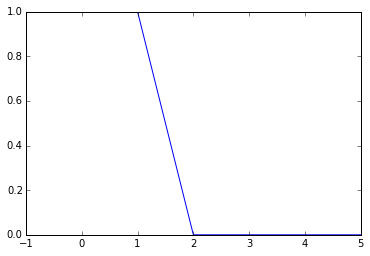

In [11]:
plt.plot(sorted(flow_num.keys()), sorted_vals)

### Trips

Now we calculate "up" trips, "down" trips, and round-trips.

In [12]:
repx_net.trips(bottom=retis.minus_ensemble, top=retis.ensembles[-1])

{'down': [], 'round': [], 'up': []}

### Transition matrix

The transition matrix is the (unsymmetrized) matrix of the transition probabilities. By default, it automatically sets its order from the Cuthill-McKee reverse ordering algorithm.

In [13]:
repx_net.transition_matrix()

,-1,0,1,5,4,3,2
-1,0.000000,0.057692,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.057692,0.000000,0.019231,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.019231,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.153846,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.153846,0.000000,0.096154,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.096154,0.000000,0.038462
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000


If you would like to set a different order, that can be done by providing a list of the ensembles in whatever order you choose:

In [14]:
order = [retis.ensembles[5], retis.ensembles[3], retis.ensembles[1], 
         retis.minus_ensemble, retis.ensembles[4], retis.ensembles[2], 
         retis.ensembles[0]]
repx_net.transition_matrix(index_order=order)

,5,3,1,-1,4,2,0
5,0.000000,0.000000,0.000000,0.000000,0.153846,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.096154,0.038462,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019231
-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.057692
4,0.153846,0.096154,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.000000,0.019231,0.057692,0.000000,0.000000,0.000000


### Mixing matrix

Same as the transition matrix $T$, but $\frac{1}{2}(T+T^T)$.

In [15]:
repx_net.mixing_matrix()

,-1,0,1,5,4,3,2
-1,0.000000,0.057692,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.057692,0.000000,0.019231,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.019231,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.153846,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.153846,0.000000,0.096154,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.096154,0.000000,0.038462
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000


### Making a pretty picture

In [16]:
repxG = paths.ReplicaNetworkGraph(repx_net)

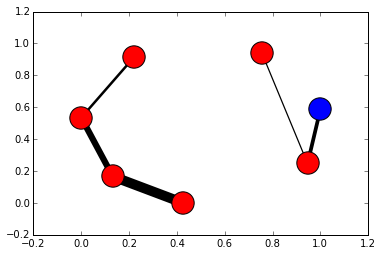

In [17]:
# draw('graphviz') gives better results, but requires pygraphviz
repxG.draw('spring')

Blue is a minus interface, red is a normal interface. Multiple state outer interfaces (not in this example) would be green.

### Alternate way of calculating transitions

There's another, perhaps better, way to calculate transitions. This does double count, but doesn't care if the how the transition happened (only that it did).

In [18]:
transitions = repx_net.transitions_from_traces(storage)

In [19]:
for (k1, k2)  in transitions.keys():
    print numeric_labels[k1], numeric_labels[k2], transitions[(k1, k2)]

3 4 5
4 5 8
3 2 2
-1 0 3
0 1 1
0 -1 3
2 3 2
1 0 1
4 3 5
5 4 8


In [20]:
for (k1, k2) in repx_net.analysis['n_accepted'].keys():
        print numeric_labels[k1], numeric_labels[k2], repx_net.analysis['n_accepted'][(k1, k2)]

4 5 8
-1 0 3
3 2 2
0 1 1
3 4 5
0 -1 3
2 3 2
1 0 1
4 3 5
5 4 8
